In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib notebook

# Append base directory
import os,sys,inspect
from pathlib import Path

currentdir = os.path.dirname(os.path.abspath(Path().resolve()))
base_dir = currentdir[:currentdir.index('python')] + 'python/'
sys.path.insert(0,base_dir)
print("Appended base directory", base_dir)

# Import external libraries
from aux.numerics.integrator_lib import integrate_ode_ord1, integrate_sde_ord1
from aux.numerics.example_ode.sho import sho_rhs, sho_energy, typelen
from aux.numerics.example_ode.double_pendulum import dp_rhs, dp_energy

Appended base directory /media/aleksejs/DataHDD/work/codes/snippets-data-analysis/python/


In [2]:
# Wrapper for computing and nicely printing PCA
def computePrintPCA(data):
    np.set_printoptions(precision=3)
    nDim = data.shape[1]

    print(str(nDim)+"D case")
    print("--------------------------------------")

    pca = PCA(n_components=nDim, svd_solver='full')
    pca.fit(data)

    print("Components:")
    for comp in pca.components_:
        print("   ", np.max(np.abs(comp)),'*', comp / np.max(np.abs(comp)))

    print("SVal:       ", pca.singular_values_)
    print("Var:        ", pca.explained_variance_ratio_)
    print("\n")

# Example 1: 1D Harmonic Oscillator

1D SHO is a 2D problem, meaning that the position and velocity at a given time are necessary to predict the state at the next time, but other variables, such as acceleration, are not necessary, as they depend directly on the former.

When we look at 3 PCA of the distribution of 3 consecutive time-steps, the princpial values come out to be position $\bar{x} = \frac{x_+ + x_0 + x_-}{3}$, velocity $v = \frac{x_+ - x_-}{2dt}$ and acceleration $a = \frac{x_+ - 2x_0 + x_-}{dt^2}$. As expected, the acceleration component is significantly lower than the other two, and does not deliver additional information in the case of a perfect oscillator, as it co-varies with position. In the case of a noisy oscillator, it does not entirely co-vary with position due to noise, so it does explain some variance.

<IPython.core.display.Javascript object>


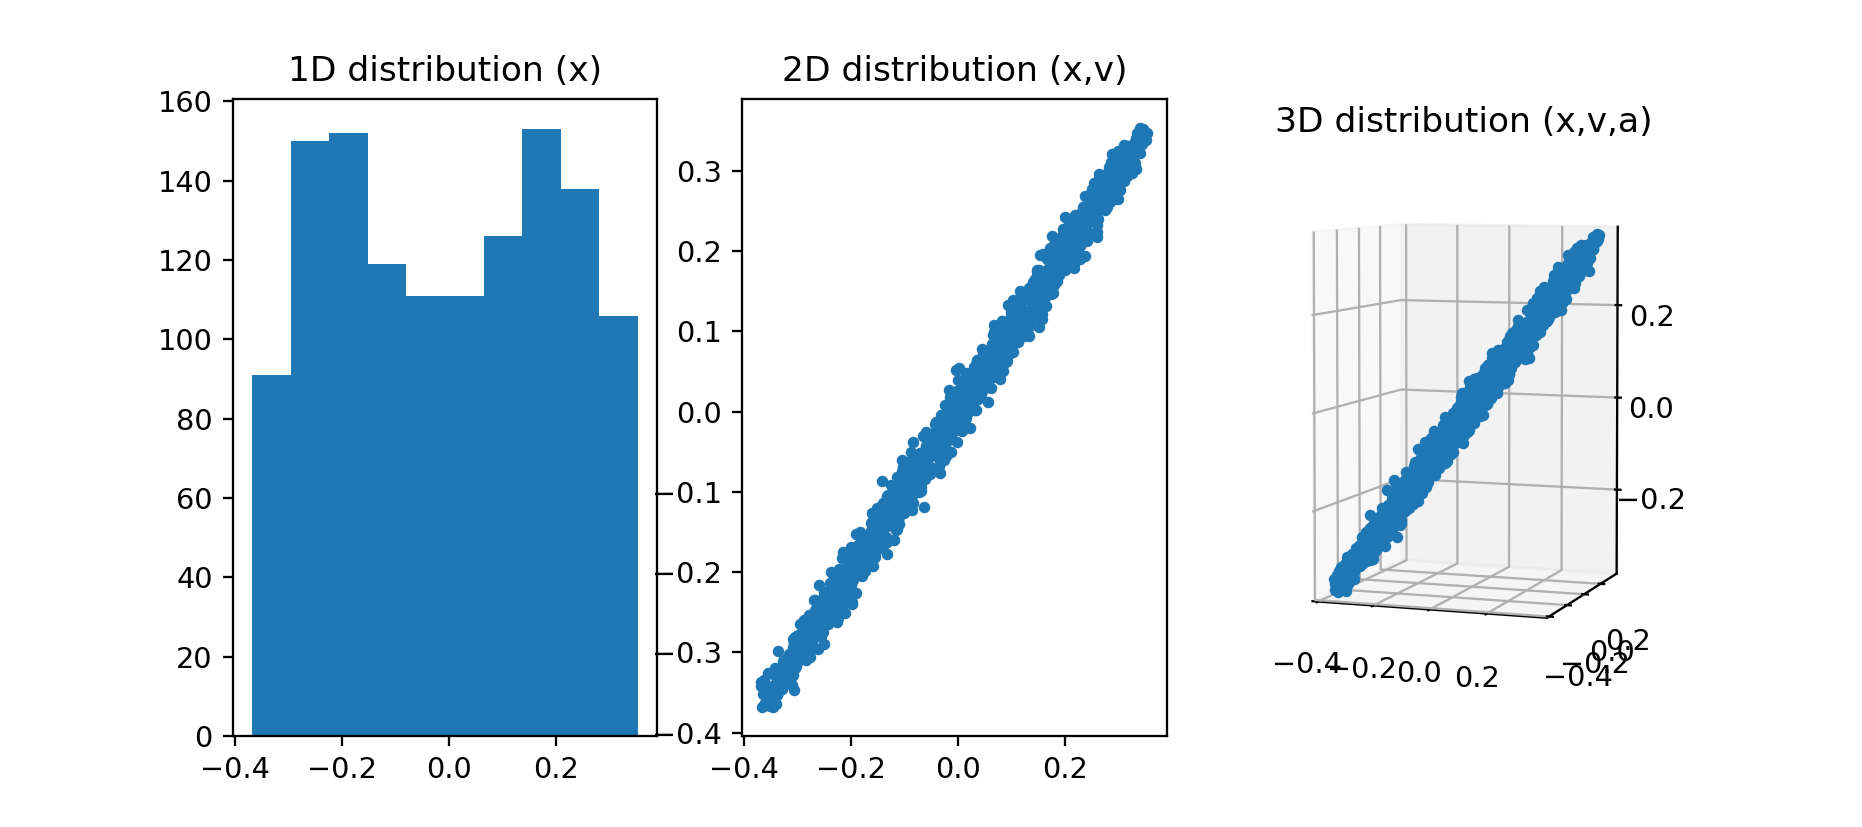

3D case
--------------------------------------
Components:
    0.5778384823622523 * [-0.999 -1.    -0.999]
    0.707156194449842 * [ 1.000e+00  2.407e-04 -9.999e-01]
    0.8161511253060054 * [-0.501  1.    -0.501]
SVal:        [12.394  0.62   0.347]
Var:         [9.967e-01 2.494e-03 7.797e-04]




In [10]:
########################
#  Compute
########################

# Define constants for SHO
N_OSC = 1
w = 5
x0 = 0.0
v0 = 1.0
dt = 0.01
nuCov = np.diag([0.0, 0.5])  # Only velocity has covariance
tau = 2 * np.pi / w  # Period
N_STEPS = int(10 * tau / dt)

# Define integrator-conforming RHS with inserted constants. Note SHO is time-invariant
F = lambda var, t: sho_rhs(var[:N_OSC], var[N_OSC:], w)
G = lambda var, t: nuCov

# Integrate the problem
#rez = integrate_ode_ord1(F, np.hstack((x0, v0)), dt, N_STEPS, method='rk4')
rez = integrate_sde_ord1(F, G, np.hstack((x0, v0)), dt, N_STEPS, eqtype='ito')

x = rez[:, 0] + np.random.normal(0, 0.01, N_STEPS+1)
v = rez[:, 1] + np.random.normal(0, 0.01, N_STEPS+1)

########################
#  Plot
########################

fig = plt.figure(figsize=(9, 4))
ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

ax0.set_title('1D distribution (x)')
ax1.set_title('2D distribution (x,v)')
ax2.set_title('3D distribution (x,v,a)')

ax0.hist(x)
ax1.plot(x[:-1], x[1:], '.')
ax2.plot(x[:-2], x[1:-1], x[2:], '.')
plt.show()

########################
#  PCA
########################

# Apply PCA
data3D = np.vstack((x[:-2], x[1:-1], x[2:])).transpose()
computePrintPCA(data3D)

# Example 2: 2D Harmonic Oscillator

Adding a second oscillator unrelated to the first one, PCA is (mostly) able to figure out when that the oscillators are disjoint.

There is an expected dramatic drop in explained variance for the accelerations, which means that they do not deliver additional information about the dynamics of the system on top of what is already known from positions and velocities. 

<IPython.core.display.Javascript object>


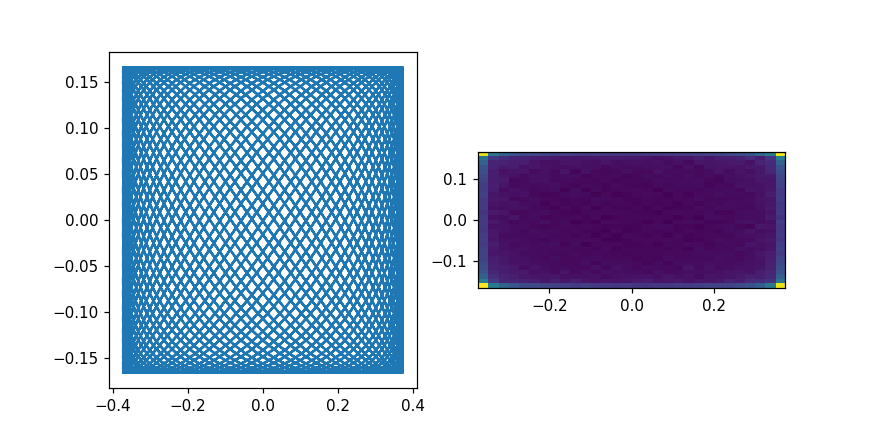

2D case
--------------------------------------
Components:
    0.9999855820629924 * [1.    0.005]
    0.9999855820629924 * [-0.005  1.   ]
SVal:        [35.142 15.569]
Var:         [0.836 0.164]


4D case
--------------------------------------
Components:
    0.7071014519094923 * [1.    1.    0.005 0.005]
    0.7071096774003279 * [-0.005 -0.006  1.     1.   ]
    0.7070860577019895 * [ 1.    -1.     0.008 -0.009]
    0.7070940074417239 * [ 0.008 -0.008 -1.     1.   ]
SVal:        [49.692 22.013  0.769  0.441]
Var:         [8.357e-01 1.640e-01 2.002e-04 6.574e-05]


6D case
--------------------------------------
Components:
    0.57752680658411 * [1.    1.    1.    0.005 0.005 0.005]
    0.5776498061807968 * [-0.005 -0.005 -0.006  0.999  1.     0.999]
    0.7070878313426002 * [ 1.000e+00 -7.527e-06 -1.000e+00  8.024e-03 -2.559e-04 -8.535e-03]
    0.7070980377026204 * [ 8.214e-03 -6.507e-05 -8.344e-03 -1.000e+00  2.193e-05  1.000e+00]
    0.793386362643275 * [ 0.121 -0.242  0.121  0.5   

In [107]:
########################
#  Compute
########################

# Define constants for SHO
N_OSC = 2
w = np.array([3.1, 4])
x0 = np.random.uniform(-1, 1, 2)
v0 = np.random.uniform(-1, 1, 2)
dt = 0.01
tau = 2 * np.pi / np.average(w)  # Period
N_STEPS = int(100 * tau / dt)

# Define integrator-conforming RHS with inserted constants. Note SHO is time-invariant
rhs = lambda var, t: np.array(sho_rhs(var[:N_OSC], var[N_OSC:], w))

# Integrate the problem
rez = integrate_ode_ord1(rhs, np.hstack((x0, v0)), dt, N_STEPS, method='scipy')

x = rez[:, :N_OSC]
v = rez[:, N_OSC:]

########################
#  Plot
########################

heatmap, xedges, yedges = np.histogram2d(x[:,0], x[:,1], bins=30)

fig, ax = plt.subplots(ncols = 2, figsize=(8,4))
ax[0].plot(x[:,0], x[:,1])
ax[1].imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower')
plt.show()

########################
#  PCA
########################

x0 = x[:, 0]
x1 = x[:, 1]

dataSets = [
    np.vstack((x0, x1)).transpose(),
    np.vstack((x0[:-1], x0[1:], x1[:-1], x1[1:])).transpose(),
    np.vstack((x0[:-2], x0[1:-1], x0[2:], x1[:-2], x1[1:-1], x1[2:])).transpose()]

for data in dataSets:
    computePrintPCA(data)

# Example 3: Double Pendulum

In order to extend to real data, we must investigate the most important aspect of real data - input from unobserved variables. The dynamics of the whole system is fully contained in the phase space of positions and velocities. Is the dynamics of the part of the system contained in a finite number of dimensions? Note that the dimensions of a 2D harmonic oscillator are independent, so it is not a very good example for this test. The simplest 2D system I can think of with 4 coupled dimensions is a double pendulum

* https://en.wikipedia.org/wiki/Double_pendulum
* http://www.phys.lsu.edu/faculty/gonzalez/Teaching/Phys7221/DoublePendulum.pdf

According to the above, the equations of motion are

$\begin{bmatrix}
    1 & \frac{\alpha}{\beta} \cos(\theta_2 - \theta_1) \\
    \beta \cos(\theta_2 - \theta_1) & 1
\end{bmatrix} \times
\begin{bmatrix}
  \ddot{\theta}_1 \\
  \ddot{\theta}_2
\end{bmatrix} = 
\begin{bmatrix}
  \alpha \dot{\theta}_2^2 \sin(\theta_2 - \theta_1) - \omega_1^2 \sin \theta_1 \\
  -\beta \dot{\theta}_1^2 \sin(\theta_2 - \theta_1) - \omega_2^2 \sin \theta_2
\end{bmatrix}
$

where

$\alpha = \frac{m_2}{m_1 + m_2}$

$\beta = \frac{l_1}{l_2}$

$\omega_1^2 = \frac{g}{l_1}$

$\omega_2^2 = \frac{g}{l_2}$

**Conclusions:**
* PCA is able to to determine linearly-dependent components (lice acceleration in harmonic oscillator), and show that they explain no additional variance on top of what is already explained by position and momentum
* PCA is unable to determine the existence of nonlinear dependence between (position, momentum) and higher derivatives (acceleration, torque) for example, in double pendulum.
* **Very Important**: Explained Variance in PCA is highly dependent on prefactors of original data. For example
    * When providing 1 step history for double pendulum, there are 4 principal components, and the first two explain 5 orders of magnitude more variance than the other two, suggesting that most of the dynamics is contained in an effective 2D phase space. However, when one performs a linear transformation, explicitly calculating positions and velocities, the drop is only one order of magnitude.
    * When providing progressively longer history for double pendulum and explicitly calculating numerical derivatives from position, the drop in explained variance for each two principal components is 2 orders of magnitude. However, if one normalizes each derivative by its variance, the drop is only one order of magnitude. This is in perfect accordance with the fact that each next derivative has one order of magnitude higher amplitude in this process.
    
**Take home messages:**
* **PCA fails to accurately determine dimensionality of nonlinear processes**. Blowing things up into higher dimension helps, but maybe there exist nonlinear component analysis strategies that would work better?
* **Avoid implicit scaling constants entering the explained variance**: When investigating Markov history of certain length, it is not ok to do PCA on the history itself. One must transform the history into dynamic variables. If it is not clear what the dynamic variables and the characteristic lengthscales of the associated processes are, one risks ignoring a scaled-down process as insignificant
* **Avoid explicit scaling constants entering the explained variance**: It is important to work with dimensionless quantities for PCA. All physical quantities such as time or length have to be normalized by the characteristic lengthscale to ensure they are comparable with other quantities
    


<IPython.core.display.Javascript object>


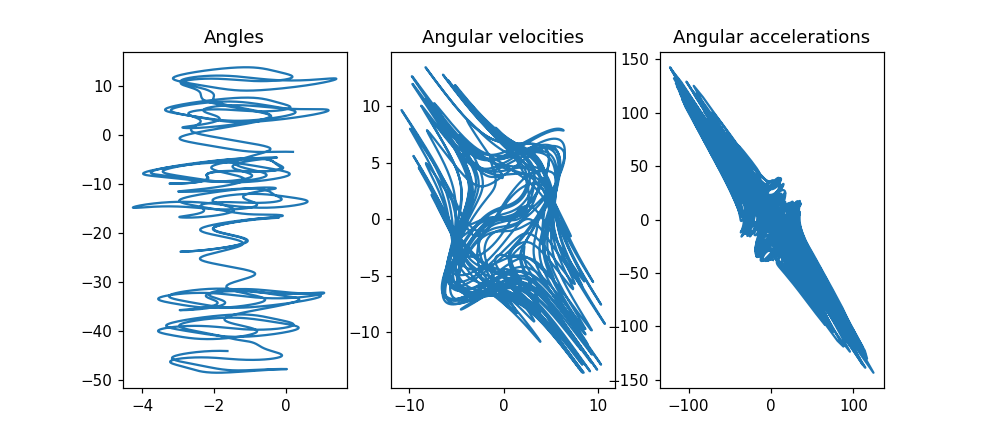

##### Computing regular PCA #######
2D case
--------------------------------------
Components:
    0.9999950391661577 * [-0.003 -1.   ]
    0.9999950391661577 * [ 1.    -0.003]
SVal:        [1355.243   93.464]
Var:         [0.995 0.005]


4D case
--------------------------------------
Components:
    0.707172257515836 * [-0.003 -0.003 -1.    -1.   ]
    0.707160796333493 * [ 1.     1.    -0.002 -0.004]
    0.7011868039987651 * [ 0.132 -0.13  -1.     1.   ]
    0.7012499330434203 * [-1.     1.    -0.131  0.131]
SVal:        [1916.346  132.151    2.613    2.081]
Var:         [9.953e-01 4.733e-03 1.850e-06 1.174e-06]


6D case
--------------------------------------
Components:
    0.5774593296567166 * [-0.003 -0.003 -0.003 -1.    -1.    -1.   ]
    0.5775395134240605 * [ 1.     1.     0.999 -0.001 -0.003 -0.005]
    0.7013105377821675 * [ 1.304e-01  1.189e-03 -1.283e-01 -1.000e+00 -2.580e-04  9.999e-01]
    0.7014303167567654 * [-9.995e-01  2.721e-04  1.000e+00 -1.296e-01  3.686e-04  1.29

In [110]:
########################
#  Compute
########################

# Parameters
g = 9.8
l1 = 1.0
l2 = 1.0
m1 = 1.0
m2 = 2.0
w1_2 = g / l1
w2_2 = g / l2
T1 = 2 * np.pi / np.sqrt(w1_2)
T2 = 2 * np.pi / np.sqrt(w2_2)

# Properties of the simulation
dt = 0.01
timeTot = 30 * max(T1, T2)
N_STEPS = int(timeTot / dt)

# Initial conditions
th0 = np.random.uniform(-0.9 * np.pi, +0.9*np.pi, 2)
vth0 = np.zeros(2)

# Define integrator-conforming RHS with inserted constants. Note that Kuramoto is time-invariant
rhs = lambda var, t: np.array(dp_rhs(var, m1,m2,l1,l2,g))

# Run simulation
#periodic = [2 * np.pi, 2 * np.pi, None, None]  # Angles are periodic, velocities are not
rez = integrate_ode_ord1(rhs, np.hstack((th0, vth0)), dt, N_STEPS, method='scipy')#, periodic=periodic)

# Postprocess
th1 = rez[:, 0] - np.pi/2
th2 = rez[:, 1] - np.pi/2
vth1 = rez[:, 2]
vth2 = rez[:, 3]
ath1 = (vth1[1:] - vth1[:-1])/dt
ath2 = (vth2[1:] - vth2[:-1])/dt

x1 = l1*np.cos(th1)
y1 = l1*np.sin(th1)
x2 = x1+l2*np.cos(th2)
y2 = y1+l2*np.sin(th2)


########################
#  Plot
########################

fig, ax = plt.subplots(ncols=3, figsize=(9, 4))
ax[0].set_title("Angles")
ax[1].set_title("Angular velocities")
ax[2].set_title("Angular accelerations")

ax[0].plot(th1, th2)
ax[1].plot(vth1, vth2)
ax[2].plot(ath1, ath2)
plt.show()

########################
#  PCA
########################

# def conseq_t(arr, n):
#     rez = np.copy(arr[:-n])
#     for i in range(n):
        
print("##### Computing regular PCA #######")
    
dataSets = [
    np.vstack((th1, th2)).transpose(),
    np.vstack((th1[:-1], th1[1:], th2[:-1], th2[1:])).transpose(),
    np.vstack((th1[:-2], th1[1:-1], th1[2:], th2[:-2], th2[1:-1], th2[2:])).transpose(),
    np.vstack((th1[:-3], th1[1:-2], th1[2:-1], th1[3:], th2[:-3], th2[1:-2], th2[2:-1], th2[3:])).transpose()]

for data in dataSets:
    computePrintPCA(data)
    

# Try to see how PCA will react if we convert timed history to derivatives. Use Finite Difference Calculator
# http://web.media.mit.edu/~crtaylor/calculator.html
print("#####  Computing PCA pre-transformed to derivatives #####")
    
th1_4D = (th1[:-3] + th1[1:-2] + th1[2:-1] + th1[3:]) / 4
th2_4D = (th2[:-3] + th2[1:-2] + th2[2:-1] + th2[3:]) / 4
vth1_4D = (th1[:-3] - 6*th1[1:-2] + 3*th1[2:-1] + 2*th1[3:]) / (6 * dt)
vth2_4D = (th2[:-3] - 6*th2[1:-2] + 3*th2[2:-1] + 2*th2[3:]) / (6 * dt)
ath1_4D = (0*th1[:-3] + th1[1:-2] - 2*th1[2:-1] + th1[3:]) / (dt**2)
ath2_4D = (0*th2[:-3] + th2[1:-2] - 2*th2[2:-1] + th2[3:]) / (dt**2)
gth1_4D = (-1*th1[:-3] + 3*th1[1:-2] - 3*th1[2:-1] + th1[3:]) / (dt**3)
gth2_4D = (-1*th2[:-3] + 3*th2[1:-2] - 3*th2[2:-1] + th2[3:]) / (dt**3)

# stDev = np.std([x1,x2,v1,v2,a1,a2,g1,g2], axis=1)
# x1 /= stDev[0]
# x2 /= stDev[1]
# v1 /= stDev[2]
# v2 /= stDev[3]
# a1 /= stDev[4]
# a2 /= stDev[5]
# g1 /= stDev[6]
# g2 /= stDev[7]

# print("Stdev", stDev)

dataSets = [
    np.vstack((th1_4D, th2_4D)).transpose(),
    np.vstack((th1_4D, vth1_4D, th2_4D, vth2_4D)).transpose(),
    np.vstack((th1_4D, vth1_4D, ath1_4D, th2_4D, vth2_4D, ath2_4D)).transpose(),
    np.vstack((th1_4D, vth1_4D, ath1_4D, gth1_4D, th2_4D, vth2_4D, ath2_4D, gth2_4D)).transpose()]

for data in dataSets:
    computePrintPCA(data)